In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [73]:
df = pd.read_csv("/content/germany_data.csv")
df.head()

,Unnamed: 0,date,total_cases,new_cases,total_deaths,new_deaths,total_tests,new_tests,people_vaccinated,people_fully_vaccinated,new_vaccinations
0,60985,2020-01-27,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60986,2020-01-28,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,60987,2020-01-29,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,60988,2020-01-30,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,60989,2020-01-31,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
train_size_per = 0.9
train_size = df.shape[0] * train_size_per
test_size = df.shape[0] - train_size 
print (f"train_size : {train_size}, test_size : {test_size}")

train_size : 731.7, test_size : 81.29999999999995


In [75]:
df.drop('total_cases', axis=1, inplace = True)
df.drop('total_deaths', axis=1, inplace = True)
df.drop('new_deaths', axis=1, inplace = True)
df.drop('new_tests', axis=1, inplace = True)
df.drop('Unnamed: 0', axis=1, inplace = True)
df.drop('total_tests', axis = 1, inplace = True)
df.drop('people_vaccinated', axis = 1, inplace = True)
df.drop('people_fully_vaccinated', axis = 1, inplace = True)
df.drop('new_vaccinations', axis=1, inplace = True)
df.drop('date', axis=1, inplace=True)
df.head()

,new_cases
0,1.0
1,3.0
2,0.0
3,0.0
4,1.0


In [76]:
df.isnull().sum()

new_cases    1
dtype: int64

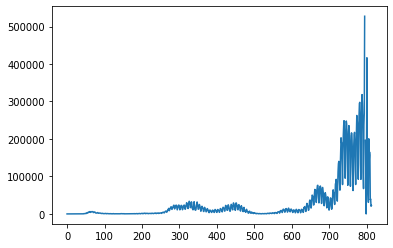

In [77]:
plt.plot(df.index, df['new_cases'])


In [78]:
train = df[:int(train_size)]
test = df[int(train_size):]

In [79]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [80]:
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)

LOOK_BACK = 14

In [81]:
X_train, y_train = create_dataset(scaled_train,LOOK_BACK)
X_test, y_test = create_dataset(scaled_test,LOOK_BACK)

In [82]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [83]:
# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer="adam",loss='mse')
    return model

model_bilstm = create_bilstm(256)
    # Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer="adam",loss="mse")
    return model
model_gru = create_gru(256)

In [84]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 1000,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop])
    return history
history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)

Epoch 1/1000
36/36 [==============================] - 4s 24ms/step - loss: 0.0016 - val_loss: 0.0308
Epoch 2/1000
36/36 [==============================] - 0s 9ms/step - loss: 9.2094e-04 - val_loss: 0.0356
Epoch 3/1000
36/36 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0365
Epoch 4/1000
36/36 [==============================] - 0s 11ms/step - loss: 0.0010 - val_loss: 0.0278
Epoch 5/1000
36/36 [==============================] - 0s 12ms/step - loss: 7.3853e-04 - val_loss: 0.0238
Epoch 6/1000
36/36 [==============================] - 0s 12ms/step - loss: 6.4933e-04 - val_loss: 0.0208
Epoch 7/1000
36/36 [==============================] - 0s 10ms/step - loss: 6.1305e-04 - val_loss: 0.0186
Epoch 8/1000
36/36 [==============================] - 0s 10ms/step - loss: 5.9419e-04 - val_loss: 0.0174
Epoch 9/1000
36/36 [==============================] - 0s 11ms/step - loss: 5.7310e-04 - val_loss: 0.0170
Epoch 10/1000
36/36 [==============================] - 0s 8ms/step -

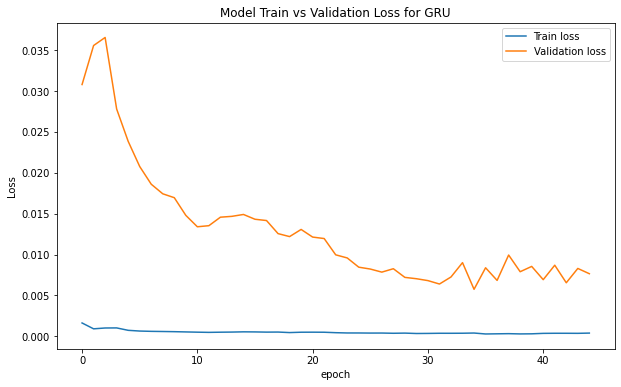

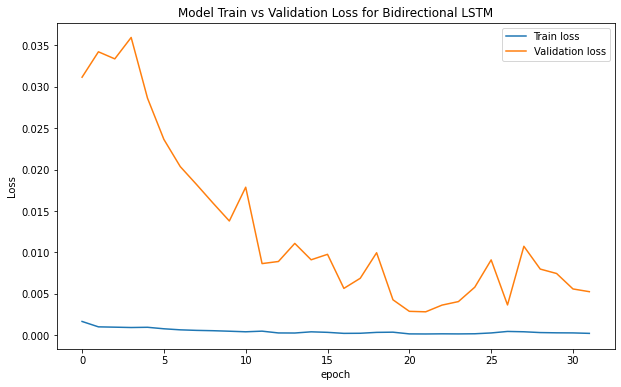

In [85]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')
plot_loss (history_bilstm, 'Bidirectional LSTM')

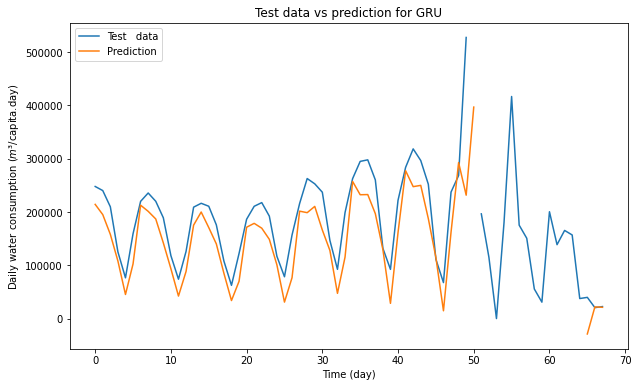

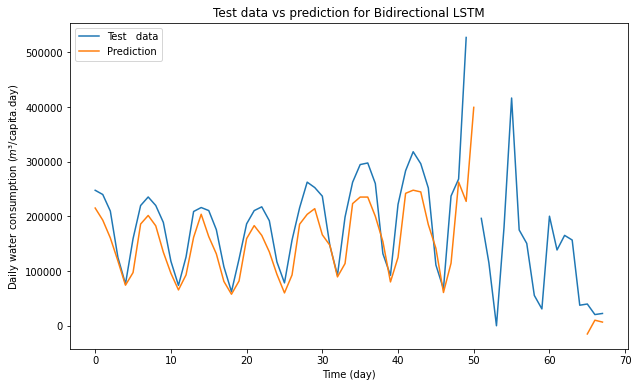

In [86]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test   data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')    
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m³$/capita.day)')
 

inv_y = scaler.inverse_transform(y_test)
plot_future(prediction_gru, 'GRU', inv_y)
plot_future(prediction_bilstm, 'Bidirectional LSTM', inv_y)